# Statistical Methods for High Dimensional Biology (STAT/BIOF/GSAT 540)


# <font color=red> Lecture 6: ANOVA and Linear Models

# Overview
In this lecture, we will go beyond 2-groups comparisons and use ANOVA to compare these groups.

### Table of Contents:

1. [**Data description**](#Data-description)
    1. [Loading the data](#Loading-the-data)
    2. [Subsetting the data](#Subsetting-the-data)

### R Dependencies:

- knitr
- lattice
- latticeExtra
- RColorBrewer

In [1]:
library(knitr)
knitr::opts_knit$set(root.dir=".")

library(dplyr)

library(ggplot2)
library(ggthemes)

library(grid)
library(gridExtra)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



# Data description

Dataset was obtained from: [GSE4051](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE4051)

> ## Targeting of GFP to new-born rods by Nrl promoter and temporal expression profiling of flow-sorted photoreceptors
Akimoto M, Cheng H, Zhu D, Brzezinski JA, Khanna R, Filippova E, Oh EC, Jing Y, Linares JL, Brooks M, Zareparsi S, Mears AJ, Hero A, Glaser T, Swaroop A.
<br><br>
The Maf-family transcription factor Nrl is a key regulator of photoreceptor differentiation in mammals. Ablation of the Nrl gene in mice leads to functional cones at the expense of rods. We show that a 2.5-kb Nrl promoter segment directs the expression of enhanced GFP specifically to rod photoreceptors and the pineal gland of transgenic mice. GFP is detected shortly after terminal cell division, corresponding to the timing of rod genesis revealed by birthdating studies. In Nrl-/- retinas, the GFP+ photoreceptors express S-opsin, consistent with the transformation of rod precursors into cones. We report the gene profiles of freshly isolated flow-sorted GFP+ photoreceptors from wild-type and Nrl-/- retinas at five distinct developmental stages. Our results provide a framework for establishing gene regulatory networks that lead to mature functional photoreceptors from postmitotic precursors. Differentially expressed rod and cone genes are excellent candidates for retinopathies.

### Overall Design
> Postmitotic rod precursors and mature rod photoreceptors are tagged by GFP under the control of an Nrl promoter in the wild type background (Wt-Gfp mice). When cross-bred into the Nrl-knockout background (Nrl-ko-Gfp mice), the transformed “S-cones” are tagged by GFP. GFP positive photoreceptors from the Wt-Gfp or Nrl-ko-Gfp retina were enriched (purified) by FACS at five distinct developmental stages (E16, P2, P6, P10, and 4 weeks). Total RNA was extracted by Trizol regent and around 50 ng of total RNA was used for linear amplification and biotin labeling following Nugene kit protocol. Fragmented cDNA was hybridized on Affymetrix mouse genomic expression array 430 2.0 and then scanned with the standard protocol. Four replicates were performed for each time point.

# Loading the data

In [2]:
prDes <- readRDS("data/GSE4051_design.rds")
str(prDes)

prDat<-read.table("data/GSE4051_data.tsv",
                  sep = "\t", header = T, row.names = 1)
str(prDat, list.len = 10)

'data.frame':	39 obs. of  4 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
'data.frame':	29949 obs. of  39 variables:
 $ Sample_20: num  7.24 9.48 10.01 8.36 8.59 ...
 $ Sample_21: num  7.41 10.02 10.04 8.37 8.62 ...
 $ Sample_22: num  7.17 9.85 9.91 8.4 8.52 ...
 $ Sample_23: num  7.07 10.13 9.91 8.49 8.64 ...
 $ Sample_16: num  7.38 7.64 8.42 8.36 8.51 ...
 $ Sample_17: num  7.34 10.03 10.24 8.37 8.89 ...
 $ Sample_6 : num  7.24 9.71 10.17 8.84 8.54 ...
 $ Sample_24: num  7.11 9.75 9.39 8.37 8.36 ...
 $ Sample_25: num  7.19 9.16 10.11 8.2 8.5 ...
 $ Sample_26: num  7.18 9.49 9.41 8.73 8.39 ...
  [list output truncated]


Here we examine the design of the study with a frequency table. We have four samples for each combination of development stage and genotype (except for "E16 and NrlKO", which has 3 samples)

In [3]:
with(prDes, table(devStage, gType))

         gType
devStage  wt NrlKO
  E16      4     3
  P2       4     4
  P6       4     4
  P10      4     4
  4_weeks  4     4

In [4]:
# Caculate total sample size of WT
wtSample <- with(prDes, sum(gType == "wt"))
paste("WT samples =", wtSample)

# Caculate total sample size of NrlKO
nrlkoSample <- with(prDes, sum(gType == "NrlKO"))
paste("NrlKO samples =", nrlkoSample)

[1] "WT samples = 20"

[1] "NrlKO samples = 19"

A cursory glance at the experession data reveals:

In [5]:
head(subset(prDat, select = 1:5))

,Sample_20,Sample_21,Sample_22,Sample_23,Sample_16
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1415670_at,7.236,7.414,7.169,7.070,7.383
1415671_at,9.478,10.020,9.854,10.130,7.637
1415672_at,10.010,10.040,9.913,9.907,8.423
1415673_at,8.362,8.374,8.404,8.487,8.363
1415674_a_at,8.585,8.615,8.520,8.641,8.509
1415675_at,9.591,9.719,9.709,9.700,9.656


# Subsetting the data

We extract the rows for each of these genes, transpose and then vectorize the data. We then merge this data together with the design metadata. Ensure that the samples match between the data and design before merging.

In [6]:
miniDat <- as.vector(t(prDat[c("1422248_at", "1450946_at"), ]))
miniDat <- data.frame(gene = rep(c("Irs4", "Nrl"), each = nrow(prDes)),
                      gExp = miniDat)
miniDat <- data.frame(prDes, miniDat) # ignore the warning about row names
str(miniDat)
head(miniDat)

Warning message in data.frame(prDes, miniDat):
"row names were found from a short variable and have been discarded"

'data.frame':	78 obs. of  6 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
 $ gene    : Factor w/ 2 levels "Irs4","Nrl": 1 1 1 1 1 1 1 1 1 1 ...
 $ gExp    : num  7.87 7.78 7.58 7.4 8.08 ...


sidChar,sidNum,devStage,gType,gene,gExp
<chr>,<dbl>,<fct>,<fct>,<fct>,<dbl>
Sample_20,20,E16,wt,Irs4,7.867
Sample_21,21,E16,wt,Irs4,7.783
Sample_22,22,E16,wt,Irs4,7.585
Sample_23,23,E16,wt,Irs4,7.400
Sample_16,16,E16,NrlKO,Irs4,8.076
Sample_17,17,E16,NrlKO,Irs4,7.515


# Code from Lecture 6

## Slide 5

In [7]:
t.test(gExp ~ gType, miniDat, subset = gene == "Irs4", var.equal = TRUE)


	Two Sample t-test

data:  gExp by gType
t = 0.52865, df = 37, p-value = 0.6002
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07383844  0.12597002
sample estimates:
   mean in group wt mean in group NrlKO 
           7.765750            7.739684 


In [8]:
summary(aov(gExp ~ gType, miniDat, subset = gene == "Irs4"))

            Df Sum Sq Mean Sq F value Pr(>F)
gType        1 0.0066 0.00662   0.279    0.6
Residuals   37 0.8764 0.02369               

In [9]:
summary(lm(gExp ~ gType, miniDat, subset = gene == "Irs4"))


Call:
lm(formula = gExp ~ gType, data = miniDat, subset = gene == "Irs4")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36575 -0.09072  0.01725  0.09428  0.36525 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.76575    0.03441 225.650   <2e-16 ***
gTypeNrlKO  -0.02607    0.04931  -0.529      0.6    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1539 on 37 degrees of freedom
Multiple R-squared:  0.007497,	Adjusted R-squared:  -0.01933 
F-statistic: 0.2795 on 1 and 37 DF,  p-value: 0.6002


## Slide 23

In [10]:
theHit <- which(rownames(prDat) == "1440645_at") # 17843
## and this as our boring gene
theBore <- which(rownames(prDat) == "1443184_at") # 18898

keepers <- data.frame(row = c(theBore, theHit),
                       probesetID = I(rownames(prDat)[c(theBore, theHit)]))

In [11]:
miniDat <- as.vector(t(prDat[keepers$probesetID, ]))
miniDat <- data.frame(gene = rep(c("theBore", "theHit"), each = nrow(prDes)),
                      gExp = miniDat)

miniDat <- data.frame(prDes, miniDat)
str(miniDat)

boreDat <- filter(miniDat, gene == "theBore")
hitDat <- filter(miniDat, gene == "theHit")

Warning message in data.frame(prDes, miniDat):
"row names were found from a short variable and have been discarded"

'data.frame':	78 obs. of  6 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
 $ gene    : Factor w/ 2 levels "theBore","theHit": 1 1 1 1 1 1 1 1 1 1 ...
 $ gExp    : num  7.59 7.96 7.43 7.58 7.98 ...


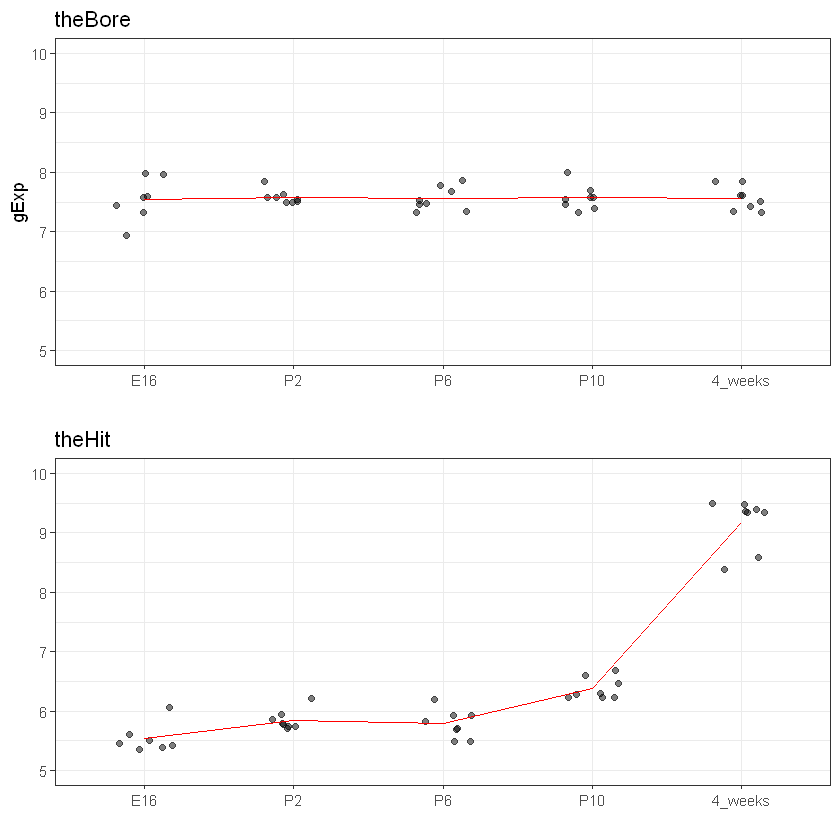

In [12]:
boreLim <- ggplot(boreDat, aes(x = devStage, y = gExp)) + 
             geom_jitter(width = 0.2, alpha = 0.5) +
             labs(title = "theBore") +
             theme_bw() +
             theme(legend.position = "none") +
             ylim(5, 10) +
             xlab("") +
             stat_summary(aes(group=1), fun.y=mean, geom="line", colour="red")

hitLim <- ggplot(hitDat, aes(x = devStage, y = gExp)) + 
             geom_jitter(width = 0.2, alpha = 0.5) +
             labs(title = "theHit") +
             theme_bw() +
             theme(legend.position = "none") +
             ylim(5, 10) +
             ylab("") +
             xlab("") +
             stat_summary(aes(group=1), fun.y=mean, geom="line", colour="red")

grid.arrange(boreLim, hitLim, nrow = 2)

## Slide 24

In [13]:
miniDat %>%
    group_by(gType,gene) %>% 
    summarize(mean(gExp))

gType,gene,mean(gExp)
<fct>,<fct>,<dbl>
wt,theBore,7.643900
wt,theHit,6.528350
NrlKO,theBore,7.477421
NrlKO,theHit,6.612632


In [14]:
summary(lm(gExp ~ devStage, miniDat, subset = gene == "theHit"))


Call:
lm(formula = gExp ~ devStage, data = miniDat, subset = gene == 
    "theHit")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.78538 -0.13299 -0.04788  0.17062  0.51814 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)       5.5409     0.1021  54.249  < 2e-16 ***
devStageP2        0.3040     0.1399   2.174   0.0368 *  
devStageP6        0.2434     0.1399   1.740   0.0909 .  
devStageP10       0.8343     0.1399   5.965 9.56e-07 ***
devStage4_weeks   3.6325     0.1399  25.973  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2702 on 34 degrees of freedom
Multiple R-squared:  0.9663,	Adjusted R-squared:  0.9623 
F-statistic: 243.4 on 4 and 34 DF,  p-value: < 2.2e-16


## Slide 38

In [15]:
twoFactFit <- lm(formula = gExp ~ gType * devStage, data = miniDat)

In [16]:
cbind(sampleMeans = theAvgs,
      minuRef = theAvgs - theAvgs["wt.E16"],
      twoFactFit = coef(twoFactFit))

Warning message in cbind(sampleMeans = theAvgs, minuRef = theAvgs - theAvgs["wt.E16"], :
"number of rows of result is not a multiple of vector length (arg 3)"

,Irs4,Nrl,Irs4,Nrl,twoFactFit
wt,7.765750,11.244200,NA,NA,6.53737500
NrlKO,7.739684,6.089632,NA,NA,0.01195833


In [17]:
theAvgs["NrlKO.4_weeks"] -
    (theAvgs["wt.E16"] +
        (theAvgs["NrlKO.E16"] - theAvgs["wt.E16"]) +
             (theAvgs["wt.4_weeks"] - theAvgs["wt.E16"]))

[1] NA

In [18]:
summary(twoFactFit)


Call:
lm(formula = gExp ~ gType * devStage, data = miniDat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18437 -0.82788 -0.05175  0.80825  1.43067 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 6.53737    0.32754  19.959  < 2e-16 ***
gTypeNrlKO                  0.01196    0.50032   0.024    0.981    
devStageP2                  0.20350    0.46321   0.439    0.662    
devStageP6                  0.06163    0.46321   0.133    0.895    
devStageP10                 0.45738    0.46321   0.987    0.327    
devStage4_weeks             2.02125    0.46321   4.364 4.46e-05 ***
gTypeNrlKO:devStageP2      -0.06533    0.68182  -0.096    0.924    
gTypeNrlKO:devStageP6       0.12829    0.68182   0.188    0.851    
gTypeNrlKO:devStageP10     -0.05533    0.68182  -0.081    0.936    
gTypeNrlKO:devStage4_weeks -0.39683    0.68182  -0.582    0.562    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Resi

# Slide 40

In [19]:
summary(lm(formula = prMat ~ gType * devStage, data = prDes))

ERROR: Error in eval(predvars, data, env): object 'prMat' not found


# Slide 41

In [ ]:
summary(lm(formula = prMatSimple ~ gType * devStage, data = prDes))